In [0]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import tqdm
plt.style.use('ggplot')
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white")

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
mainPath = "/content/gdrive/My Drive/Hackathons" 

In [0]:
read_path = "/Sapient/data/"

In [0]:
file = "Type1.csv"

In [6]:
data = pd.read_csv(mainPath+read_path + file)
data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,157878,0,Cash loans,M,Y,N,2,247500.0,945000.0,40167.0,945000.0,Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,0.019101,-15322,365243,-7733.0,-4788,1,0,0,1,0,0,4.0,2,2,WEDNESDAY,16,0,0,0,0,0,0,XNA,0.623227,0.622922,2.0,2.0,2.0,2.0,-1965,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,2.0
1,157879,0,Revolving loans,M,N,Y,2,180000.0,540000.0,27000.0,540000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.006207,-11120,-61,-953.0,-3474,1,1,0,1,1,0,4.0,2,2,SATURDAY,13,0,1,1,0,1,1,Business Entity Type 3,0.430050,0.656158,0.0,0.0,0.0,0.0,-1585,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,157880,0,Cash loans,F,N,Y,0,112500.0,295168.5,16011.0,238500.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.030755,-11824,-4467,-1193.0,-2370,1,1,1,1,0,0,2.0,2,2,SUNDAY,14,0,0,0,0,0,0,Business Entity Type 2,0.447755,0.524496,0.0,0.0,0.0,0.0,-1708,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
3,157882,0,Cash loans,F,N,Y,0,67500.0,640080.0,24259.5,450000.0,Unaccompanied,State servant,Secondary / secondary special,Married,House / apartment,0.018850,-13642,-1955,-3880.0,-4466,1,1,1,1,1,0,2.0,2,2,FRIDAY,16,0,0,0,0,0,0,Postal,0.615054,0.454321,10.0,5.0,10.0,4.0,-1590,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,2.0
4,157883,0,Cash loans,F,N,N,0,157500.0,325908.0,17811.0,247500.0,Unaccompanied,Working,Higher education,Married,Municipal apartment,0.016612,-11347,-4719,-10610.0,-3404,1,1,0,1,0,0,2.0,2,2,FRIDAY,18,0,0,0,1,1,0,Other,0.442273,0.771362,0.0,0.0,0.0,0.0,-1250,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,2.0,0.0


In [7]:
data.shape

(204579, 72)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204579 entries, 0 to 204578
Data columns (total 72 columns):
SK_ID_CURR                     204579 non-null int64
TARGET                         204579 non-null int64
NAME_CONTRACT_TYPE             204579 non-null object
CODE_GENDER                    204579 non-null object
FLAG_OWN_CAR                   204579 non-null object
FLAG_OWN_REALTY                204579 non-null object
CNT_CHILDREN                   204579 non-null int64
AMT_INCOME_TOTAL               204579 non-null float64
AMT_CREDIT                     204579 non-null float64
AMT_ANNUITY                    204579 non-null float64
AMT_GOODS_PRICE                204579 non-null float64
NAME_TYPE_SUITE                204579 non-null object
NAME_INCOME_TYPE               204579 non-null object
NAME_EDUCATION_TYPE            204579 non-null object
NAME_FAMILY_STATUS             204579 non-null object
NAME_HOUSING_TYPE              204579 non-null object
REGION_POPULATION_RELATI

### MainCode

In [0]:
part = data.select_dtypes(include= 'object')

In [10]:
part.shape

(204579, 11)

In [0]:
train_small_with_dummies = pd.get_dummies(part, dtype ='int64')

In [0]:
data.drop(columns= part.columns, inplace= True)

In [13]:
data.shape

(204579, 61)

In [0]:
df1 = data.join(train_small_with_dummies)

In [15]:
df1.shape

(204579, 165)

In [0]:
df1.drop(columns = ['SK_ID_CURR'],inplace = True)

In [17]:
df1.head()

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,...,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA
0,0,2,247500.0,945000.0,40167.0,945000.0,0.019101,-15322,365243,-7733.0,-4788,1,0,0,1,0,0,4.0,2,2,16,0,0,0,0,0,0,0.623227,0.622922,2.0,2.0,2.0,2.0,-1965,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,2,180000.0,540000.0,27000.0,540000.0,0.006207,-11120,-61,-953.0,-3474,1,1,0,1,1,0,4.0,2,2,13,0,1,1,0,1,1,0.430050,0.656158,0.0,0.0,0.0,0.0,-1585,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,112500.0,295168.5,16011.0,238500.0,0.030755,-11824,-4467,-1193.0,-2370,1,1,1,1,0,0,2.0,2,2,14,0,0,0,0,0,0,0.447755,0.524496,0.0,0.0,0.0,0.0,-1708,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,67500.0,640080.0,24259.5,450000.0,0.018850,-13642,-1955,-3880.0,-4466,1,1,1,1,1,0,2.0,2,2,16,0,0,0,0,0,0,0.615054,0.454321,10.0,5.0,10.0,4.0,-1590,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,157500.0,325908.0,17811.0,247500.0,0.016612,-11347,-4719,-10610.0,-3404,1,1,0,1,0,0,2.0,2,2,18,0,0,0,1,1,0,0.442273,0.771362,0.0,0.0,0.0,0.0,-1250,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Model

In [0]:
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn import  metrics
from sklearn.model_selection import cross_validate

In [19]:
train = df1[:143205]
train.shape

(143205, 164)

In [20]:
test = df1[143205:]
test.shape

(61374, 164)

In [21]:
trainX = train.iloc[:,1:]
trainX.shape

(143205, 163)

In [22]:
trainY = train.iloc[:,0]
trainY.shape

(143205,)

In [23]:
testX = test.iloc[:,1:]
testX.shape

(61374, 163)

In [24]:
testY = test.iloc[:,0]
testY.shape

(61374,)

In [0]:
lgb_train = lgb.Dataset(trainX, trainY)
lgb_eval = lgb.Dataset(testX,testY, reference=lgb_train)

In [26]:
trainY.value_counts()

0    131954
1     11251
Name: TARGET, dtype: int64

In [27]:
lgbm_params = {
    'boosting': 'dart',
    'application': 'binary',
    'learning_rate': 0.02,
    'min_data_in_leaf': 30,
    'num_leaves': 34,
    'max_depth': 8,
    'feature_fraction': 0.9497036,
    'scale_pos_weight': 11,
    'drop_rate': 0.02,
    'reg_alpha': 0.041545473,
    'reg_lambda': 0.0735294,
    'min_split_gain': 0.0222415,
    'min_child_weight': 39.3259775,
}


cv_results = lgb.cv(train_set=lgb_train,
                     params=lgbm_params,
                     nfold=5,
                     num_boost_round=1000,
                     early_stopping_rounds=200,
                     stratified=True,
                     verbose_eval=50,
                     metrics=['auc'])

optimum_boost_rounds = np.argmax(cv_results['auc-mean'])
print('Optimum boost rounds = {}'.format(optimum_boost_rounds))
print('Best LGBM CV result = {}'.format(np.max(cv_results['auc-mean'])))

/usr/local/lib/python3.6/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[50]	cv_agg's auc: 0.73908 + 0.00426594
[100]	cv_agg's auc: 0.74199 + 0.00401138
[150]	cv_agg's auc: 0.742485 + 0.00399336
[200]	cv_agg's auc: 0.743772 + 0.00380844
[250]	cv_agg's auc: 0.74475 + 0.00367899
[300]	cv_agg's auc: 0.745957 + 0.00361205
[350]	cv_agg's auc: 0.746723 + 0.0036139
[400]	cv_agg's auc: 0.747766 + 0.00349477
[450]	cv_agg's auc: 0.748765 + 0.00349205
[500]	cv_agg's auc: 0.749182 + 0.00342936
[550]	cv_agg's auc: 0.74948 + 0.00334095
[600]	cv_agg's auc: 0.750215 + 0.00322554
[650]	cv_agg's auc: 0.750515 + 0.00328957
[700]	cv_agg's auc: 0.750562 + 0.00327333
[750]	cv_agg's auc: 0.750755 + 0.00316752
[800]	cv_agg's auc: 0.750799 + 0.00314256
[850]	cv_agg's auc: 0.750874 + 0.00312273
[900]	cv_agg's auc: 0.751153 + 0.00312896
[950]	cv_agg's auc: 0.751061 + 0.00317181
[1000]	cv_agg's auc: 0.751037 + 0.003178
Optimum boost rounds = 899
Best LGBM CV result = 0.7511530504477141


In [0]:
clf = lgb.train(train_set=lgb_train,
                 params=lgbm_params,
                 num_boost_round=optimum_boost_rounds)
                 
""" Predict on test set and create submission """
y_pred = clf.predict(testX)

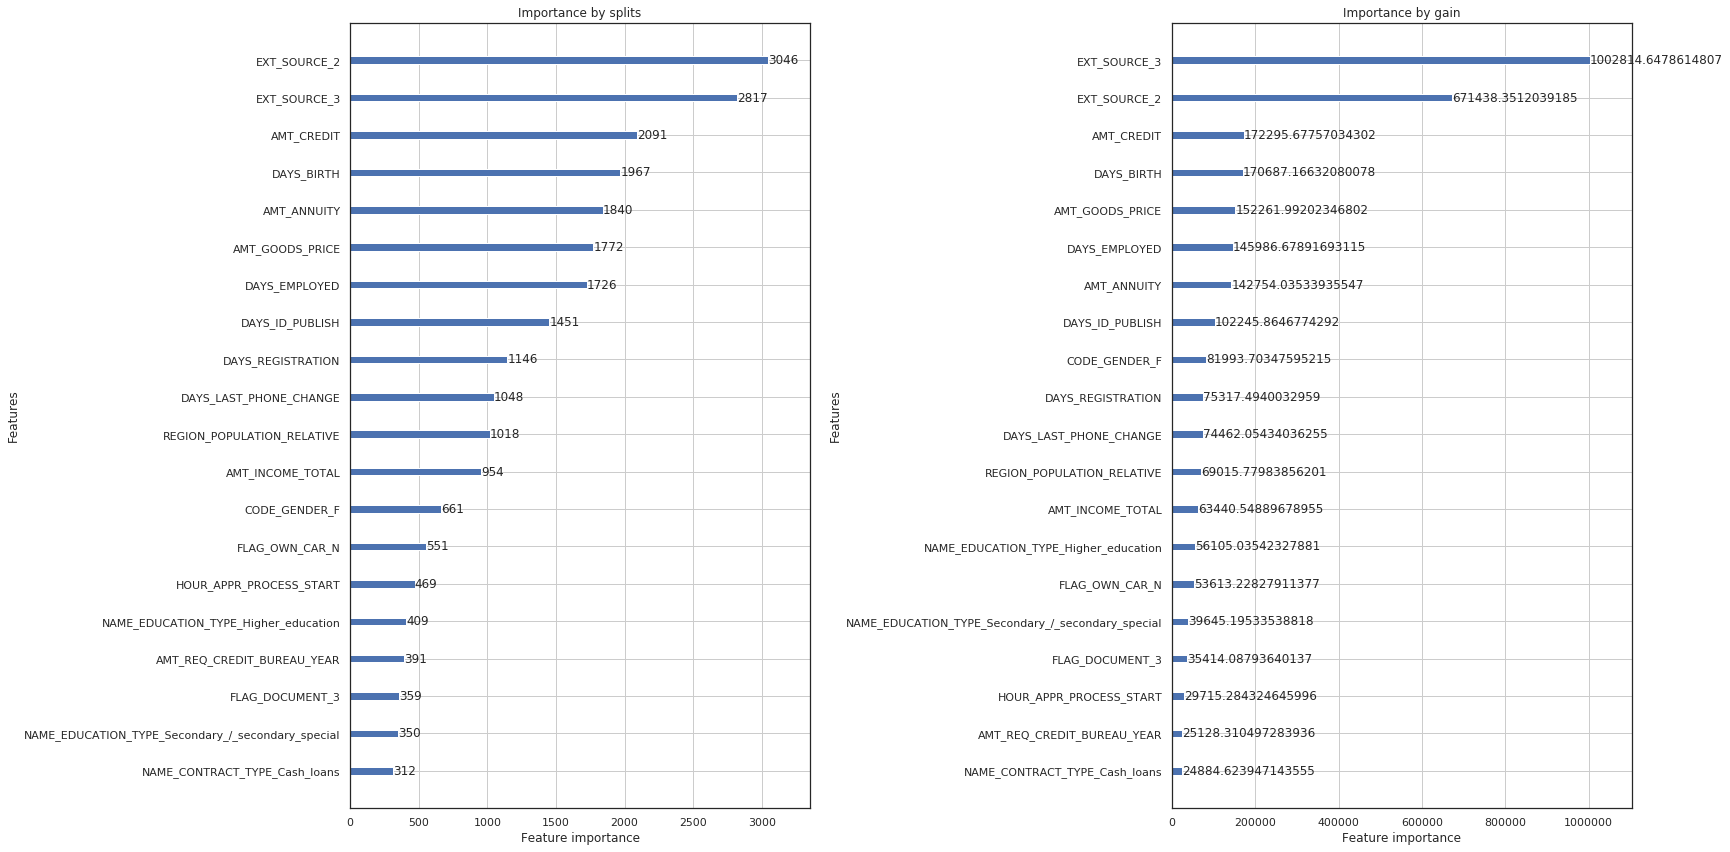

In [29]:
# Plot importances
fig, (ax, ax1) = plt.subplots(1, 2, figsize=[24, 12])
lgb.plot_importance(clf, ax=ax, max_num_features=20, importance_type='split')
lgb.plot_importance(clf, ax=ax1, max_num_features=20, importance_type='gain')
ax.set_title('Importance by splits')
ax1.set_title('Importance by gain')
plt.tight_layout()

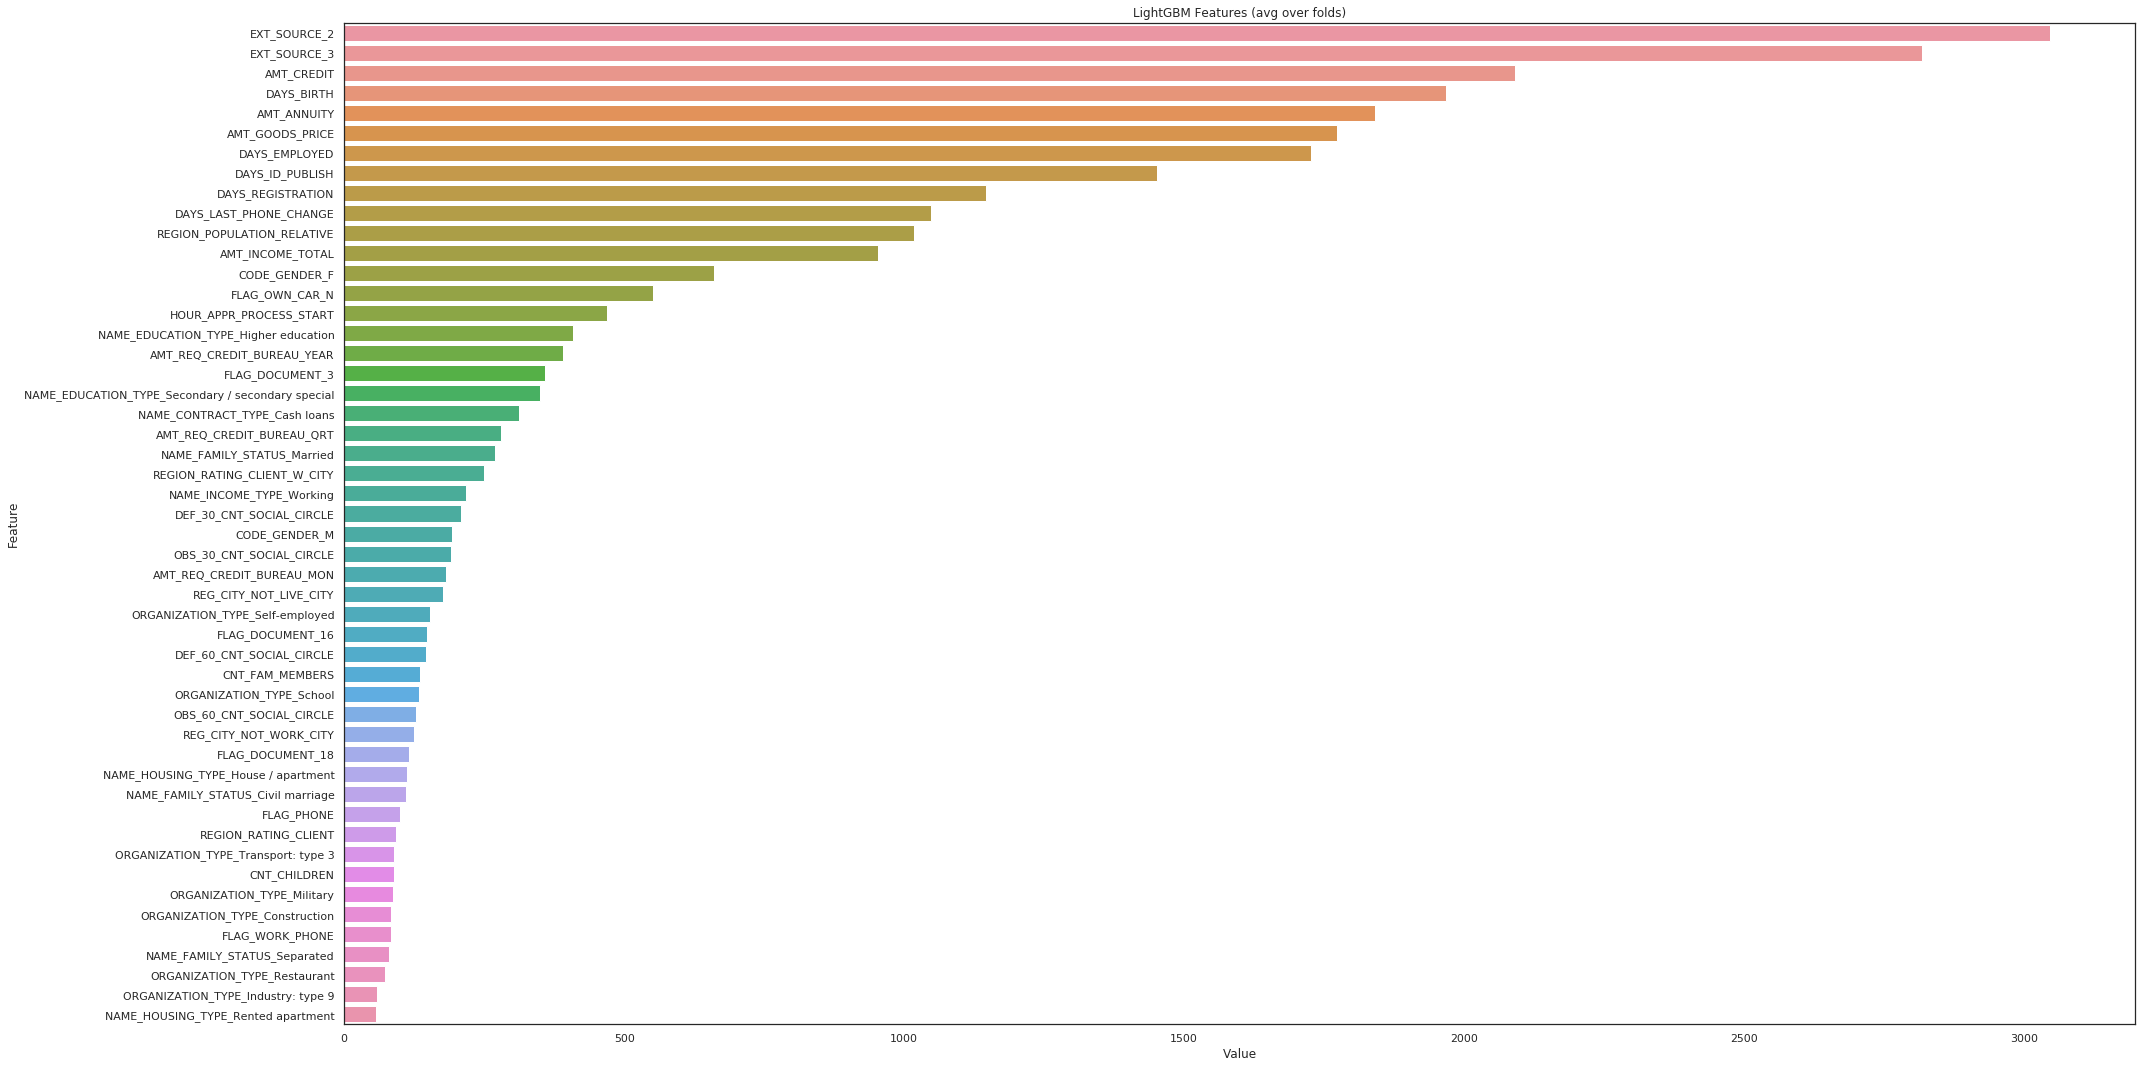

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def plotImp(model, X , num = 20):
    feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(),X.columns)), 
                               columns=['Value','Feature'])
    plt.figure(figsize=(30, 15))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()
    
plotImp(clf,trainX,50)

In [0]:
feature_imp = pd.DataFrame(sorted(zip(trainX.columns,clf.feature_importance())), 
                               columns=['Feature','Value'])

In [0]:
feature_imp.sort_values(by="Value", ascending=False, inplace= True)
feature_imp.reset_index(inplace = True, drop= True)

In [0]:
select = list(feature_imp[:30].Feature)

In [34]:
select

['EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'AMT_CREDIT',
 'DAYS_BIRTH',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'DAYS_EMPLOYED',
 'DAYS_ID_PUBLISH',
 'DAYS_REGISTRATION',
 'DAYS_LAST_PHONE_CHANGE',
 'REGION_POPULATION_RELATIVE',
 'AMT_INCOME_TOTAL',
 'CODE_GENDER_F',
 'FLAG_OWN_CAR_N',
 'HOUR_APPR_PROCESS_START',
 'NAME_EDUCATION_TYPE_Higher education',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'FLAG_DOCUMENT_3',
 'NAME_EDUCATION_TYPE_Secondary / secondary special',
 'NAME_CONTRACT_TYPE_Cash loans',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'NAME_FAMILY_STATUS_Married',
 'REGION_RATING_CLIENT_W_CITY',
 'NAME_INCOME_TYPE_Working',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'CODE_GENDER_M',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'REG_CITY_NOT_LIVE_CITY',
 'ORGANIZATION_TYPE_Self-employed']

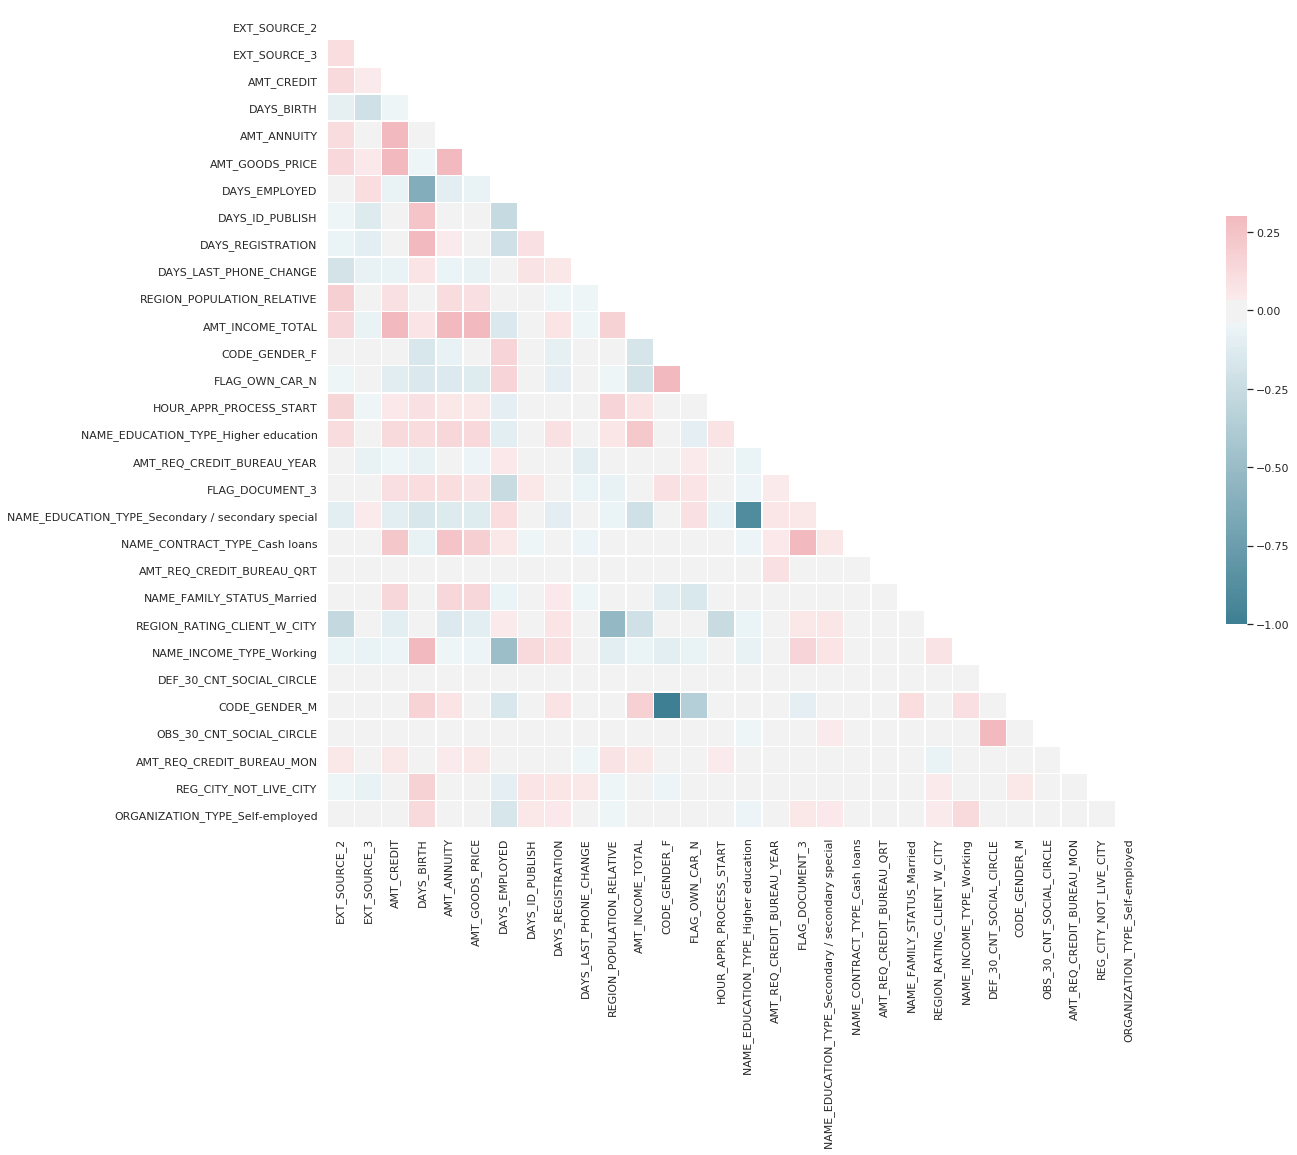

In [35]:
corr = df1[select].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(30, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [0]:
target = 'TARGET'

In [0]:
def modelfit(alg, dtrain, dtest, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        xgtest = xgb.DMatrix(dtest[predictors].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
          metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['TARGET'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain['TARGET'].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['TARGET'], dtrain_predprob))
    
#     Predict on testing data:
    dtest_pred = alg.predict_proba(dtest[predictors])[:,1]
#    results = test_results.merge(dtest[['ID','predprob']], on='ID')
    print ('AUC Score (Test): %f' % metrics.roc_auc_score(dtest['TARGET'], dtest_pred ))
    

In [0]:
predictors = [x for x in train.columns if x not in [target]]

In [39]:
xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=300,
        max_depth=3,
        min_child_weight=5,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=-1,
        scale_pos_weight=11,
        seed=27, verbose = True)
modelfit(xgb1, train, test, predictors)


Model Report
Accuracy : 0.7342
AUC Score (Train): 0.787709
AUC Score (Test): 0.755671
